## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

print('OK')

OK


In [2]:
print(objp.shape)
print(corners.shape)
print("(images, points, coord) =",np.shape(objpoints))
print("(images, points, coord1,coord2) =",np.shape(imgpoints))

(54, 3)
(54, 1, 2)
(images, points, coord) = (17, 54, 3)
(images, points, coord1,coord2) = (17, 54, 1, 2)


### Camera calibration matrices

In [3]:
img = cv2.imread("camera_cal/calibration1.jpg")
img_size = img.shape[:2][::-1]
print(img_size)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

(1280, 720)


### Examples of undistorted image

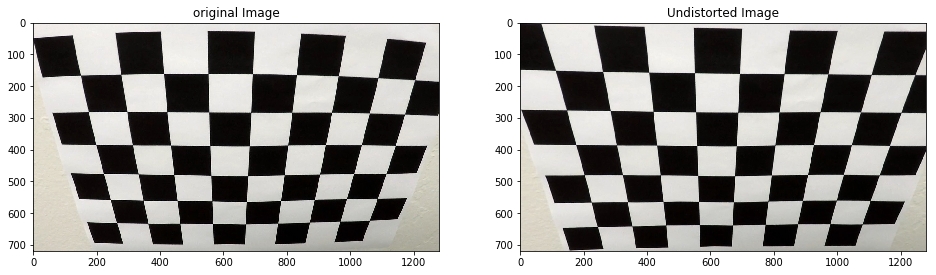

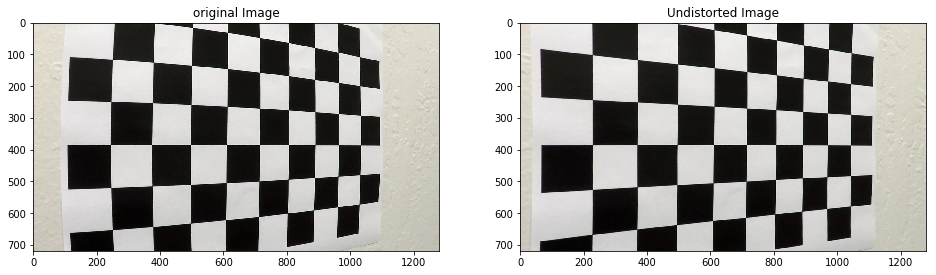

In [11]:
%matplotlib inline

def show_undistort_image(img,mtx,dist):
    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_undistort =  cv2.undistort(imgRGB, mtx, dist, None, mtx)
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    plt.title("original Image")
    plt.imshow(imgRGB)
    
    plt.subplot(1,2,2)
    plt.title("Undistorted Image")
    plt.imshow(img_undistort)
    
show_undistort_image(cv2.imread("camera_cal/calibration2.jpg"),mtx,dist)
show_undistort_image(cv2.imread("camera_cal/calibration5.jpg"),mtx,dist)

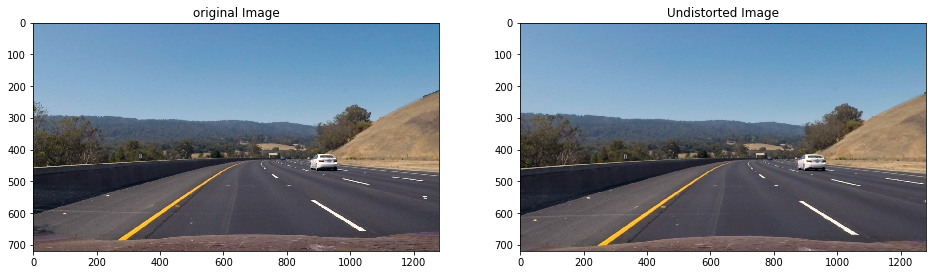

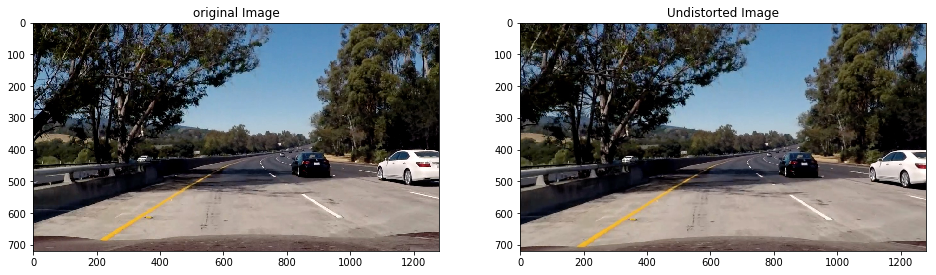

In [13]:
show_undistort_image(cv2.imread("test_images/test3.jpg"),mtx,dist)
show_undistort_image(cv2.imread("test_images/test5.jpg"),mtx,dist)

## Define color thresh function

In [33]:
def color_thresh(img, threshLow, threshHigh):
    # Convert to HLS color space
    imgHSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
   
    # Return a binary image of threshold result
    binary_output = np.zeros((img.shape[0], img.shape[1]))
    
    binary_output[(imgHSV[:,:,0] >= threshLow[0]) & (imgHSV[:,:,0] <= threshHigh[0]) & (imgHSV[:,:,1] >= threshLow[1])  & (imgHSV[:,:,1] <= threshHigh[1])  & (imgHSV[:,:,2] >= threshLow[2]) & (imgHSV[:,:,2] <= threshHigh[2])] = 1
                 
    return binary_output

In [34]:
#Magnitude threshold
def sobel_x(img, sobel_kernel=3,min_thres = 20, max_thres =100):
    # Apply the following steps to img
    # 1) Convert to grayscale
    imghsl = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Take the gradient in x and y separately
    #Channels L and S from HLS
    sobelx1 = cv2.Sobel(imghsl[:,:,1], cv2.CV_64F, 1,0, ksize=sobel_kernel)
    sobelx2 = cv2.Sobel(imghsl[:,:,2], cv2.CV_64F, 1,0, ksize=sobel_kernel)
        
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobelx1 = np.uint8(255*sobelx1/ np.max(sobelx1))
    scaled_sobelx2 = np.uint8(255*sobelx2/ np.max(sobelx2))

    # 5) Create a binary mask where mag thresholds are met
    binary_outputx1 = np.zeros_like(scaled_sobelx1)
    binary_outputx1[(scaled_sobelx1 >= min_thres) & (scaled_sobelx1 <= max_thres)] = 1

    binary_outputx2 = np.zeros_like(scaled_sobelx2)
    binary_outputx2[(scaled_sobelx2 >= min_thres) & (scaled_sobelx2 <= max_thres)] = 1

    binary_output = np.zeros_like(scaled_sobelx1)
    binary_output[(binary_outputx1 ==1) | (binary_outputx2 ==1)]=1
    # 6) Return this mask as your binary_output image
    return binary_output


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0,1, ksize=sobel_kernel)
    
    # 3) Calculate the magnitude 
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*gradmag / np.max(gradmag))
       
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1


    # 6) Return this mask as your binary_output image
    return binary_output


#Direction threshold
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0,1, ksize=sobel_kernel)

    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)

    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(abs_sobely, abs_sobelx) 

    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return binary_output

#Both Magnitude and direction threshold
def mag_dir_thresh(img, sobel_kernel=3, mag_thresh=(0, 255), dir_thresh=(0,np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1,0, ksize=sobel_kernel) 
    sobely = cv2.Sobel(img, cv2.CV_64F, 0,1, ksize=sobel_kernel)
    
    # 3) Calculate the magnitude 
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    #Calc angle
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    absgraddir = np.arctan2(abs_sobely, abs_sobelx) 

    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*gradmag / np.max(gradmag))
       
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1]) & (absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1]) ] = 1


    # 6) Return this mask as your binary_output image
    return binary_output

Examples of color thresholds


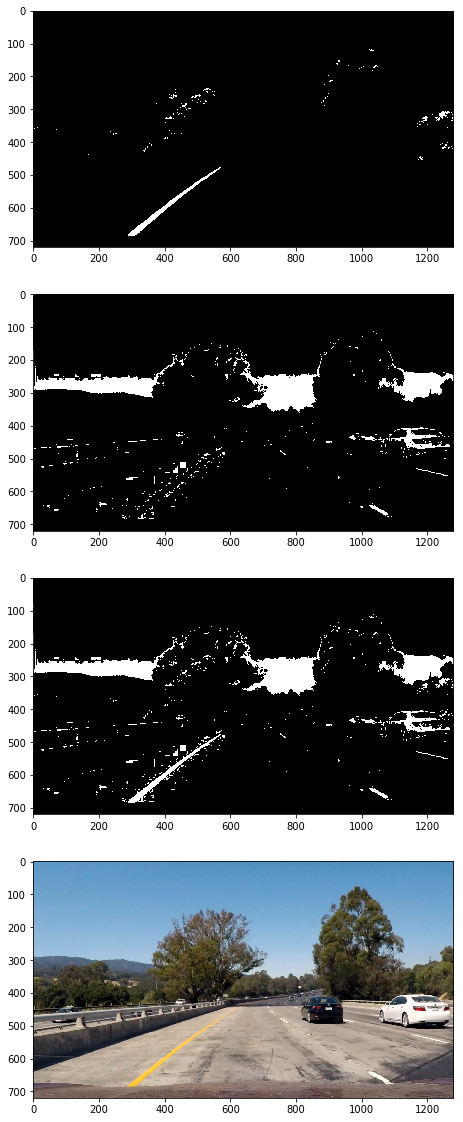

In [38]:
#Examples of color thresholds

img = cv2.imread("test_images/test1.jpg")
#img = cv2.imread("test_images/straight_lines2.jpg")

imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#imgHLS = cv2.cvtColor(imgRGB, cv2.COLOR_RGB2HLS)
#print(np.max(imgHLS[:,:,0]))

print("Examples of color thresholds")

yellow_low = np.array([0,100,100])
yellow_high = np.array([50,255,255])

white_low = np.array([18,0,180])
white_high = np.array([255,80,255])


imgThres_yellow = hls_color_thresh(imgRGB,yellow_low,yellow_high)
imgThres_white = hls_color_thresh(imgRGB,white_low,white_high)


imgThres_both =np.zeros_like(imgThres_yellow)

imgThres_both[(imgThres_yellow==1) | (imgThres_white==1)] =1

plt.figure(figsize=(20,20))
plt.subplot(4,1,1)
plt.imshow(imgThres_yellow,cmap ='gray')
plt.subplot(4,1,2)
plt.imshow(imgThres_white,cmap ='gray')

plt.subplot(4,1,3)
plt.imshow(imgThres_both,cmap ='gray')
           
plt.subplot(4,1,4)
plt.imshow(imgRGB)

Examples of magnitude and direction thresholds


<Figure size 720x576 with 0 Axes>

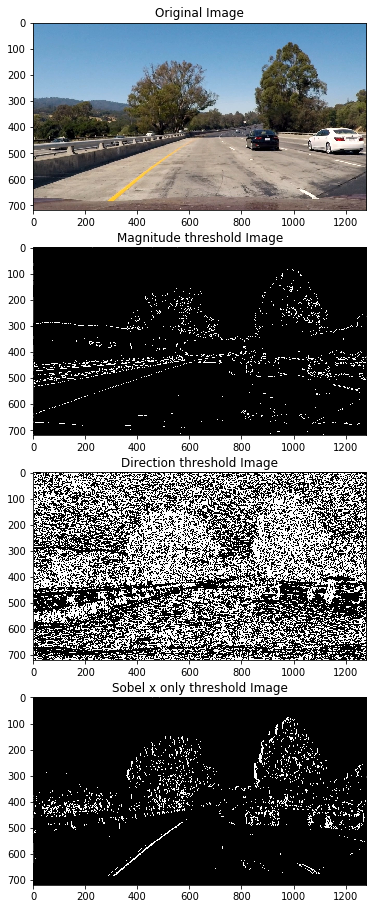

In [40]:
#Examples of magnitude and direction thresholds
plt.figure(figsize=(10,8))

img = cv2.imread("test_images/test1.jpg")
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

magThr =mag_thresh(imgRGB, 3, (50, 100))
#imgDirThr =dir_threshold(img, 9,(np.pi/2*30/90, np.pi/2*60/90))
#magThr =mag_dir_thresh(imgRGB, 9, (100,255)) #Only magnitude

dirThr =dir_threshold(imgRGB, 9,(np.pi/240/90, np.pi/2*60/90))
#dirThr =mag_dir_thresh(imgRGB, 9,(50,100) ,(np.pi/2*30/90, np.pi/2*60/90))
#Only direction
#imgThr =mag_dir_thresh(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 9, (30, 255),(np.pi/2*60/90, np.pi/2*120/90)) #Both

#Sobel x only
imgThr = sobel_x(imgRGB,9,80,220) #Sobel x

print("Examples of magnitude and direction thresholds")
plt.figure(figsize=(20,20))

plt.subplot(5,1,1)
plt.title('Original Image')
fig =plt.imshow(imgRGB)

plt.subplot(5,1,2)
plt.title('Magnitude threshold Image')
fig =plt.imshow(magThr,cmap = 'gray')

plt.subplot(5,1,3)
plt.title('Direction threshold Image')
fig =plt.imshow(dirThr,cmap = 'gray')

plt.subplot(5,1,4)
plt.title('Sobel x only threshold Image')
fig =plt.imshow(imgThr,cmap = 'gray')


#imgThresColor = hls_color_thresh(imgRGB,(20,30),(150,255),(200,255))
#imgThr =mag_dir_thresh(imgThresColor, 3, (30, 255),(np.pi/2*50/90, np.pi/2*90/90)) #Both

#plt.subplot(5,1,5)
#plt.title('Color and threshold Image')
#fig =plt.imshow(imgThr,cmap = 'gray')

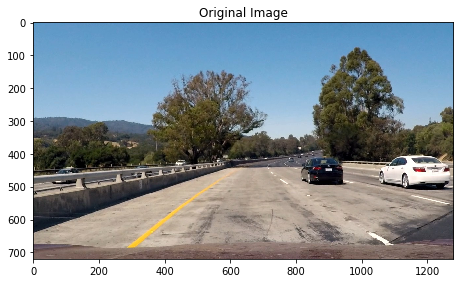

In [41]:
#Birds eye view

img = cv2.imread("test_images/test1.jpg")
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


plt.figure(figsize=(30,20))

plt.subplot(4,1,1)
plt.title('Original Image')
fig =plt.imshow(imgRGB)


#Plotar pontos 

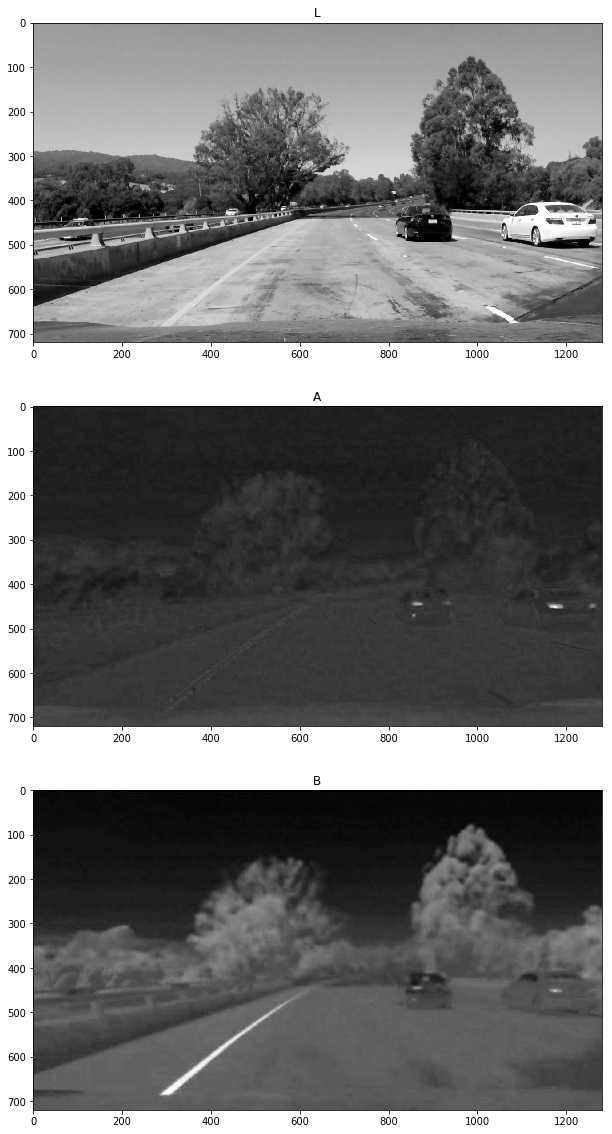

In [43]:
#Test to see the effects of HSL channel

img = cv2.imread("test_images/test1.jpg")
imgHSV = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

plt.figure(figsize=(20,20))

plt.subplot(3,1,1)
plt.title('L')
fig =plt.imshow(imgHSV[:,:,0],cmap='gray')
plt.subplot(3,1,2)
plt.title('A')
fig =plt.imshow(imgHSV[:,:,1],cmap='gray')
plt.subplot(3,1,3)
plt.title('B')
fig =plt.imshow(imgHSV[:,:,2],cmap='gray')

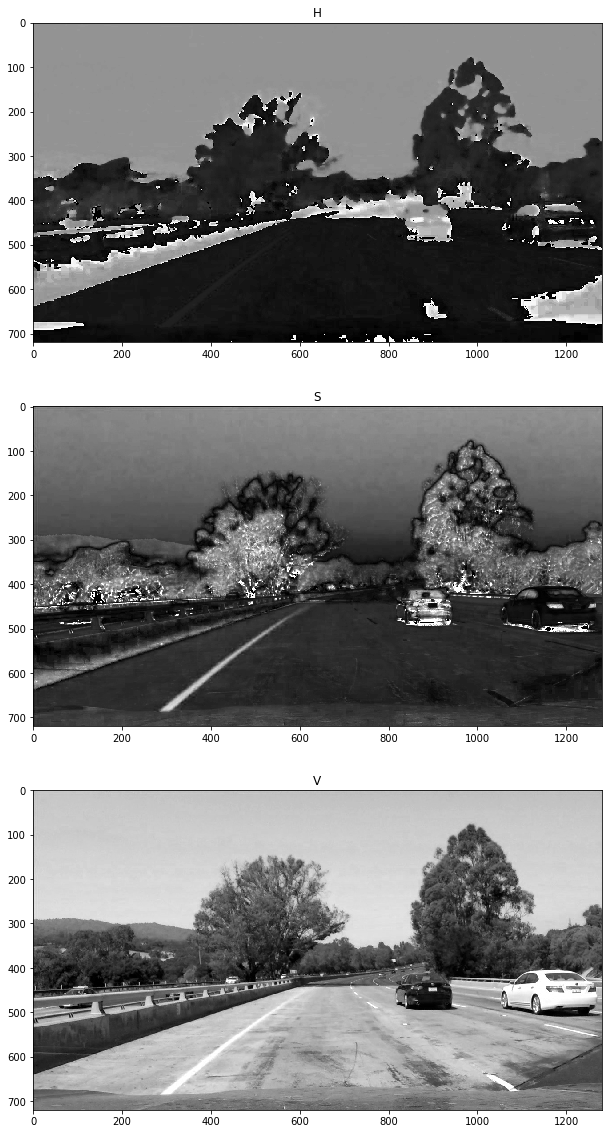

In [46]:
#Test to see the effects of HSL channel

img = cv2.imread("test_images/test1.jpg")
imgHSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

plt.figure(figsize=(20,20))

plt.subplot(3,1,1)
plt.title('H')
fig =plt.imshow(imgHSV[:,:,0],cmap='gray')
plt.subplot(3,1,2)
plt.title('S')
fig =plt.imshow(imgHSV[:,:,1],cmap='gray')
plt.subplot(3,1,3)
plt.title('V')
fig =plt.imshow(imgHSV[:,:,2],cmap='gray')

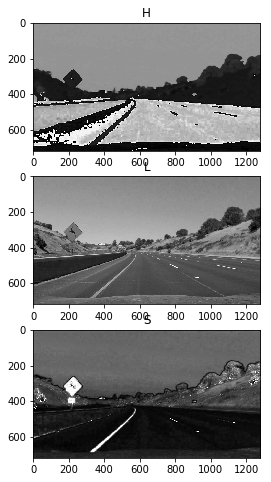

In [47]:
img = cv2.imread("test_images/test1.jpg")
img = cv2.imread("test_images/test2.jpg")
imgHLS = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

plt.figure(figsize=(10,8))

plt.subplot(3,1,1)
plt.title('H')
fig =plt.imshow(imgHLS[:,:,0],cmap='gray')
plt.subplot(3,1,2)
plt.title('L')
fig =plt.imshow(imgHLS[:,:,1],cmap='gray')
plt.subplot(3,1,3)
plt.title('S')
fig =plt.imshow(imgHLS[:,:,2],cmap='gray')

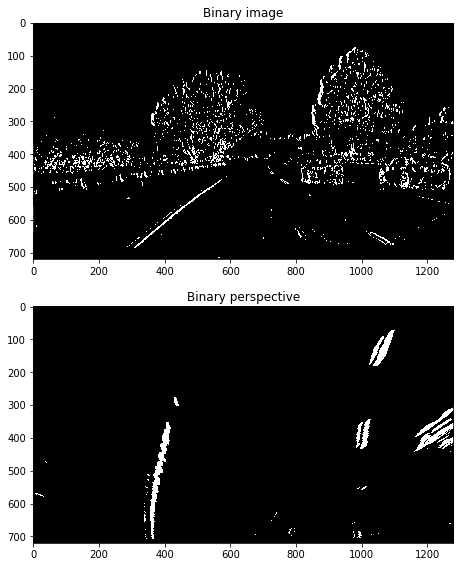

In [48]:
#Perspective transfomation

src = np.float32([[585, 450], [203, 720], [1127, 720], [695, 450]])
dst = np.float32([[320, 0], [320, 720], [960,720], [960, 0]])

M_persp = cv2.getPerspectiveTransform(src, dst)
Minv_persp = cv2.getPerspectiveTransform(dst, src)

img_size = (imgThr.shape[1], imgThr.shape[0])
binary_warped = cv2.warpPerspective(imgThr, M_persp, img_size, flags=cv2.INTER_LINEAR)


plt.figure(figsize=(30,20))

plt.subplot(4,1,1)
plt.title('Binary image')
fig =plt.imshow(imgThr, cmap='gray')

plt.subplot(4,1,2)
plt.title('Binary perspective')
fig =plt.imshow(binary_warped, cmap='gray')

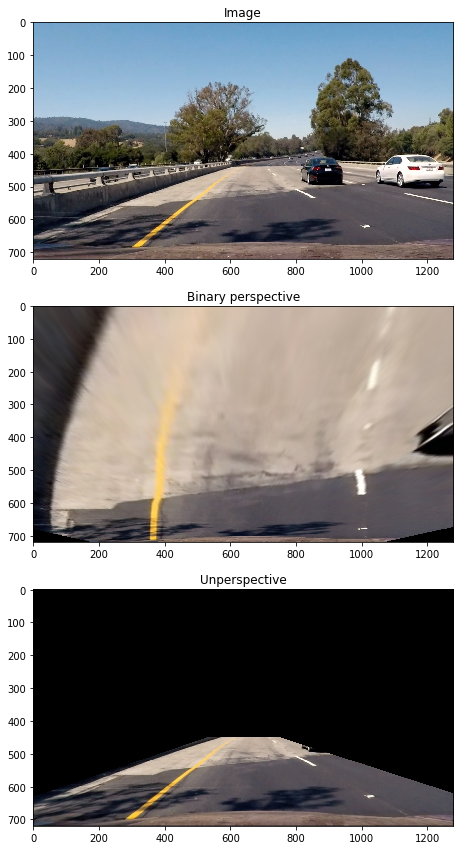

In [50]:
#Perspective transfomation
img = cv2.imread("test_images/test4.jpg")
#img = cv2.imread("test_images/straight_lines2.jpg")

imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img2 = cv2.undistort(imgRGB, mtx, dist, None, mtx)

img_size = (img2.shape[1], img2.shape[0])

RGB_warped = cv2.warpPerspective(img2, M_persp, img_size, flags=cv2.INTER_LINEAR)


plt.figure(figsize=(20,20))

plt.subplot(4,1,1)
plt.title('Image')
fig =plt.imshow(imgRGB)

plt.subplot(4,1,2)
plt.title('Binary perspective')
fig =plt.imshow(RGB_warped)



img_unpersp = cv2.warpPerspective(RGB_warped, Minv_persp, img_size, flags=cv2.INTER_LINEAR)
plt.subplot(4,1,3)
plt.title('Unperspective')
fig =plt.imshow(img_unpersp)

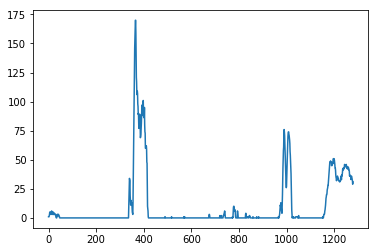

In [52]:
#Example histogram

histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [53]:
#print(binary_warped.shape)
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
#plt.imshow(out_img)

midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

print("leftx_base",leftx_base, "rightx_base",rightx_base)

nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()

leftx_base 365 rightx_base 990


In [56]:
def fitlines(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
   
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    
    # Fit a second order polynomial to each
    if len(leftx) == 0:
        left_fit =[]
    else:
        left_fit = np.polyfit(lefty, leftx, 2)
    
    if len(rightx) == 0:
        right_fit =[]
    else:
        right_fit = np.polyfit(righty, rightx, 2)
    

    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]


    return left_fit, right_fit,out_img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/Users/andy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(720, 1280, 3)
255.0
ok


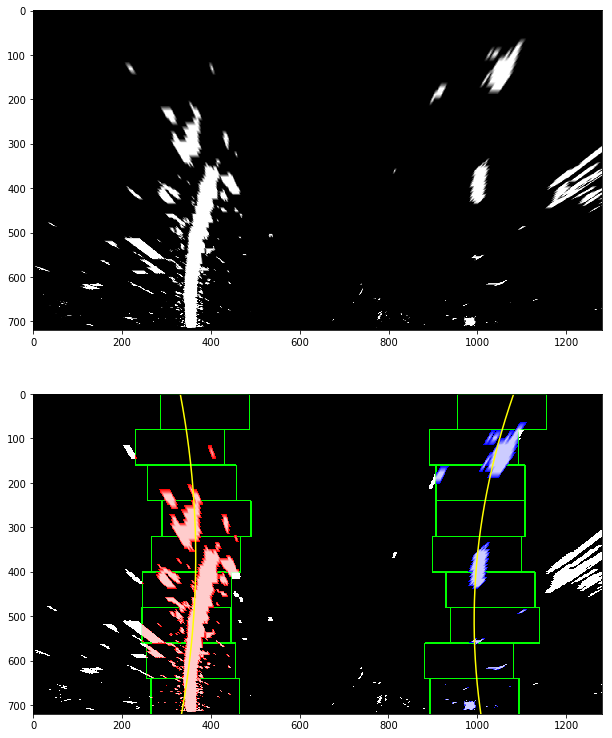

In [57]:
#Visualization of lines fitted
img = cv2.imread("test_images/test1.jpg")
#img = cv2.imread("test_images/straight_lines2.jpg")
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_undist = cv2.undistort(imgRGB, mtx, dist, None, mtx)

#2.Magnitude Threshold
#Threshold color    
yellow_low = np.array([0,100,100])
yellow_high = np.array([50,255,255])
white_low = np.array([18,0,180])
white_high = np.array([255,80,255])
global ref_left 
global ref_right
global left_fit
global right_fit

imgThres_yellow = hls_color_thresh(img_undist,yellow_low,yellow_high)
imgThres_white = hls_color_thresh(img_undist,white_low,white_high)
imgThr_sobelx = sobel_x(img_undist,9,80,220) #Sobel x

img_mag_thr =np.zeros_like(imgThres_yellow)
#imgThresColor[(imgThres_yellow==1) | (imgThres_white==1)] =1
img_mag_thr[(imgThres_yellow==1) | (imgThres_white==1) | (imgThr_sobelx==1)] =1
img_mag_thr[(imgThres_yellow==1) | (imgThres_white==1)] =1


#3. Birds-eye
#Perspective array pre-calculated
img_size = (img_mag_thr.shape[1], img_mag_thr.shape[0])
binary_warped = cv2.warpPerspective(img_mag_thr, M_persp, img_size, flags=cv2.INTER_LINEAR)

left_fit, right_fit,out_img = fitlines(binary_warped)


print(out_img.shape)
print(np.max(out_img))


ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    

plt.figure(figsize=(30,20))
plt.subplot(3,1,1)
plt.imshow(binary_warped, cmap='gray')

plt.subplot(3,1,2)

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

plt.subplot(3,1,2)
binary_warped2 = np.zeros((720, 1280,3))
binary_warped2[:,:,0] = binary_warped
binary_warped2[:,:,1] = binary_warped
binary_warped2[:,:,2] = binary_warped
plt.imshow(out_img)
result = cv2.addWeighted(binary_warped2, .8, out_img, .8, 0)
plt.imshow(result)
print("ok")

In [58]:
def fit_continuous(left_fit, right_fit, binary_warped):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    if len(leftx) == 0:
        left_fit_updated =[]
    else:
        left_fit_updated = np.polyfit(lefty, leftx, 2)
    
    
    if len(rightx) == 0:
        right_fit_updated =[]
    else:
        right_fit_updated = np.polyfit(righty, rightx, 2)
        
    return  left_fit_updated, right_fit_updated

In [59]:
#Calc Curvature
def curvature(left_fit, right_fit, binary_warped):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension


    # Fit new polynomials to x,y in world space
    #leftx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    #rightx = right_fit[0]*ploty**2+right_fit[1]*ploty+left_fit[2]
        
    #left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    #right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    center = (((left_fit[0]*720**2+left_fit[1]*720+left_fit[2]) +(right_fit[0]*720**2+right_fit[1]*720+right_fit[2]) ) /2 - 640)*xm_per_pix
    
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    return left_curverad, right_curverad, center

In [60]:
#Draw line and return image

def drawLine(undist, warped,left_fit, right_fit):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    # Fit new polynomials to x,y in world space
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2] 
    
    #print(left_fitx)
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))


    #print(np.int_(pts))


    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (255,215, 0))

    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv_persp, (color_warp.shape[1], color_warp.shape[0])) 

    # Combine the result with the original image
    
    #print("undist", undist.shape)
    #print("newwarp", newwarp.shape)
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    #result = cv2.addWeighted(undist, 0, newwarp, 1, 0)
    return(result, color_warp)


In [61]:
def sanity_check(left_fit, right_fit, minSlope, maxSlope):
    #Performs a sanity check on the lanes
    #Check 1: check if left and right fits exists
    #Check 2: Calculates the tangent between left and right in two points, and check if it is in a reasonable threshold
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    if len(left_fit) ==0 or len(right_fit) == 0:
        status = False
        d0=0
        d1=0
        #Previous fitlines routine returns empty list to them if not finds
    else:
        #Difference of slope
        L_0 = 2*left_fit[0]*460+left_fit[1]
        R_0 = 2*right_fit[0]*460+right_fit[1]
        d0 =  np.abs(L_0-R_0)

        L_1 = 2*left_fit[0]*720+left_fit[1]
        R_1 = 2*right_fit[0]*720+right_fit[1]
        d1 =  np.abs(L_1-R_1)

        
        if d0>= minSlope and d0<= maxSlope and d1>= minSlope and d1<= maxSlope:
            status = True
        else:
            status = False
            
    return(status, d0, d1)

In [62]:
#Function to process the image
global counter
counter=0
ref_left =np.array([-0.0001,0,400])
ref_right=np.array([-0.0001,0,1000])   
left_fit =np.array([-0.0001,0,400])
right_fit=np.array([-0.0001,0,1000])   



def process_image(image):
    #1. Camera correction
    #Calibration arrays pre-calculated
    img_undist = cv2.undistort(image, mtx, dist, None, mtx)
    global counter
    
    #2.Magnitude Threshold
    #Threshold color    
    yellow_low = np.array([0,100,100])
    yellow_high = np.array([50,255,255])
    white_low = np.array([18,0,180])
    white_high = np.array([255,80,255])
    global ref_left 
    global ref_right
    global left_fit
    global right_fit

    imgThres_yellow = hls_color_thresh(img_undist,yellow_low,yellow_high)
    imgThres_white = hls_color_thresh(img_undist,white_low,white_high)
    imgThr_sobelx = sobel_x(img_undist,9,80,220) #Sobel x

    img_mag_thr =np.zeros_like(imgThres_yellow)
    #imgThresColor[(imgThres_yellow==1) | (imgThres_white==1)] =1
    img_mag_thr[(imgThres_yellow==1) | (imgThres_white==1) | (imgThr_sobelx==1)] =1
        
    #3. Birds-eye
    #Perspective array pre-calculated
    img_size = (img_mag_thr.shape[1], img_mag_thr.shape[0])
    binary_warped = cv2.warpPerspective(img_mag_thr, M_persp, img_size, flags=cv2.INTER_LINEAR)
    
    #4. Detect lanes and return fit curves
    
    if counter==0:
        left_fit, right_fit,out_imgfit = fitlines(binary_warped)
    else:
        left_fit, right_fit = fit_continuous(left_fit, right_fit, binary_warped)
    
    
    #Project video (2.8, 3.5)
    status_sanity, d0, d1 =sanity_check(left_fit, right_fit, 0, .55)
    #Challenge video (2.4,3.1)
    #status_sanity, d0, d1, d2 =sanity_check(left_fit, right_fit, 2.4,3.1)
    
    #print(left_fit)
    #print(right_fit)
    
    #Calc curvature and center
    if status_sanity  == True:        
        #Save as last reliable fit
        ref_left, ref_right = left_fit, right_fit        
        counter+=1
    else:        #Use the last realible fit
        left_fit, right_fit = ref_left, ref_right
        
    left_curv, right_curv, center_off = curvature(left_fit, right_fit, binary_warped)

    #Warp back to original and merge with image    
    img_merge, img_birds = drawLine(img_undist, binary_warped,left_fit, right_fit)

    #Composition of images to final display
    img_out=np.zeros((576,1280,3), dtype=np.uint8)

    img_out[0:576,0:1024,:] =cv2.resize(img_merge,(1024,576))
    #b) Threshold
    img_out[0:288,1024:1280, 0] =cv2.resize(img_mag_thr*255,(256,288))
    img_out[0:288,1024:1280, 1] =cv2.resize(img_mag_thr*255,(256,288))
    img_out[0:288,1024:1280, 2] =cv2.resize(img_mag_thr*255,(256,288))
    #c)Birds eye view
    img_out[310:576,1024:1280,:] =cv2.resize(img_birds,(256,266))
    
    
    #Write curvature and center in image
    TextL = "Left curv: " + str(int(left_curv)) + " m"
    TextR = "Right curv: " + str(int(right_curv))+ " m"
    TextC = "Center offset: " + str(round( center_off,2)) + "m"
    #TextAux = str(status_sanity) + ", d0: " + str(round(d0,2)) + ", d1: " + str(round(d1,2))
    fontScale=1
    thickness=2
    
    fontFace = cv2.FONT_HERSHEY_SIMPLEX


    cv2.putText(img_out, TextL, (130,40), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out, TextR, (130,70), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out, TextC, (130,100), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    #cv2.putText(img_out, TextAux, (100,130), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)

    cv2.putText(img_out, "Thresh. view", (1070,30), fontFace, .8,(200,200,0), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out, "Birds-eye", (1080,305), fontFace, .8,(200,200,0), thickness,  lineType = cv2.LINE_AA)
        
    
    #return img_out, binary_warped, left_curv, right_curv, left_fit, right_fit   
    return img_out 

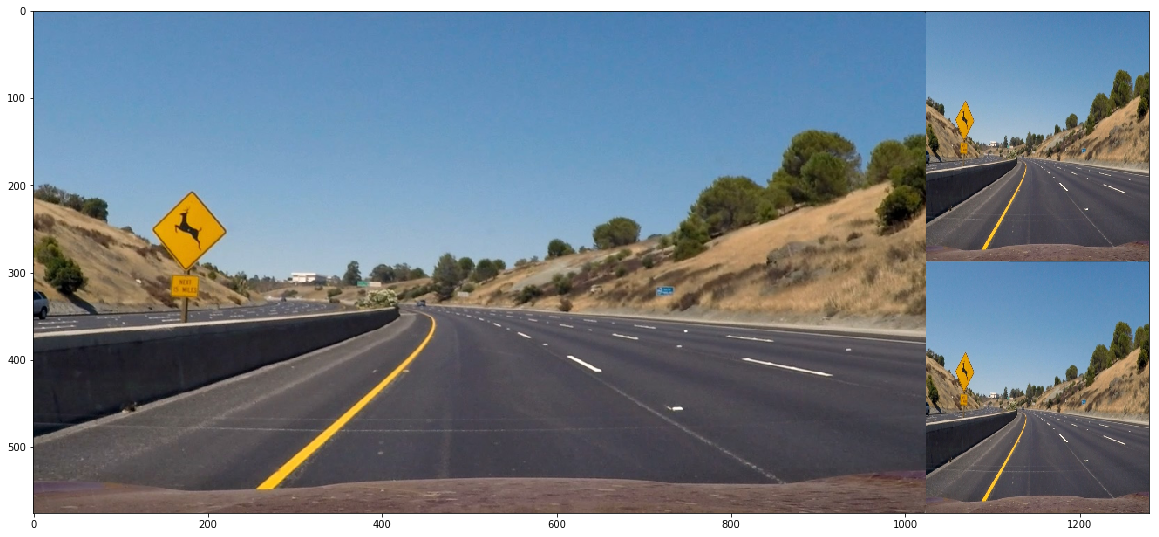

In [67]:
#Test composition images
img = cv2.imread("test_images/test2.jpg")
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_out=np.zeros((576,1280,3), dtype=np.uint8)

img_out[0:576,0:1024,0:3] =cv2.resize(imgRGB,(1024,576))
#b) Threshold
img_out[0:288,1024:1280, :] =cv2.resize(imgRGB,(256,288))
#c)Birds eye view
img_out[288:576,1024:1280,:] =cv2.resize(imgRGB,(256,288))


#img2 = cv2.resize(imgRGB,(1024,576))
plt.figure(figsize=(20,20))
plt.imshow(img_out)

<Figure size 720x1080 with 0 Axes>

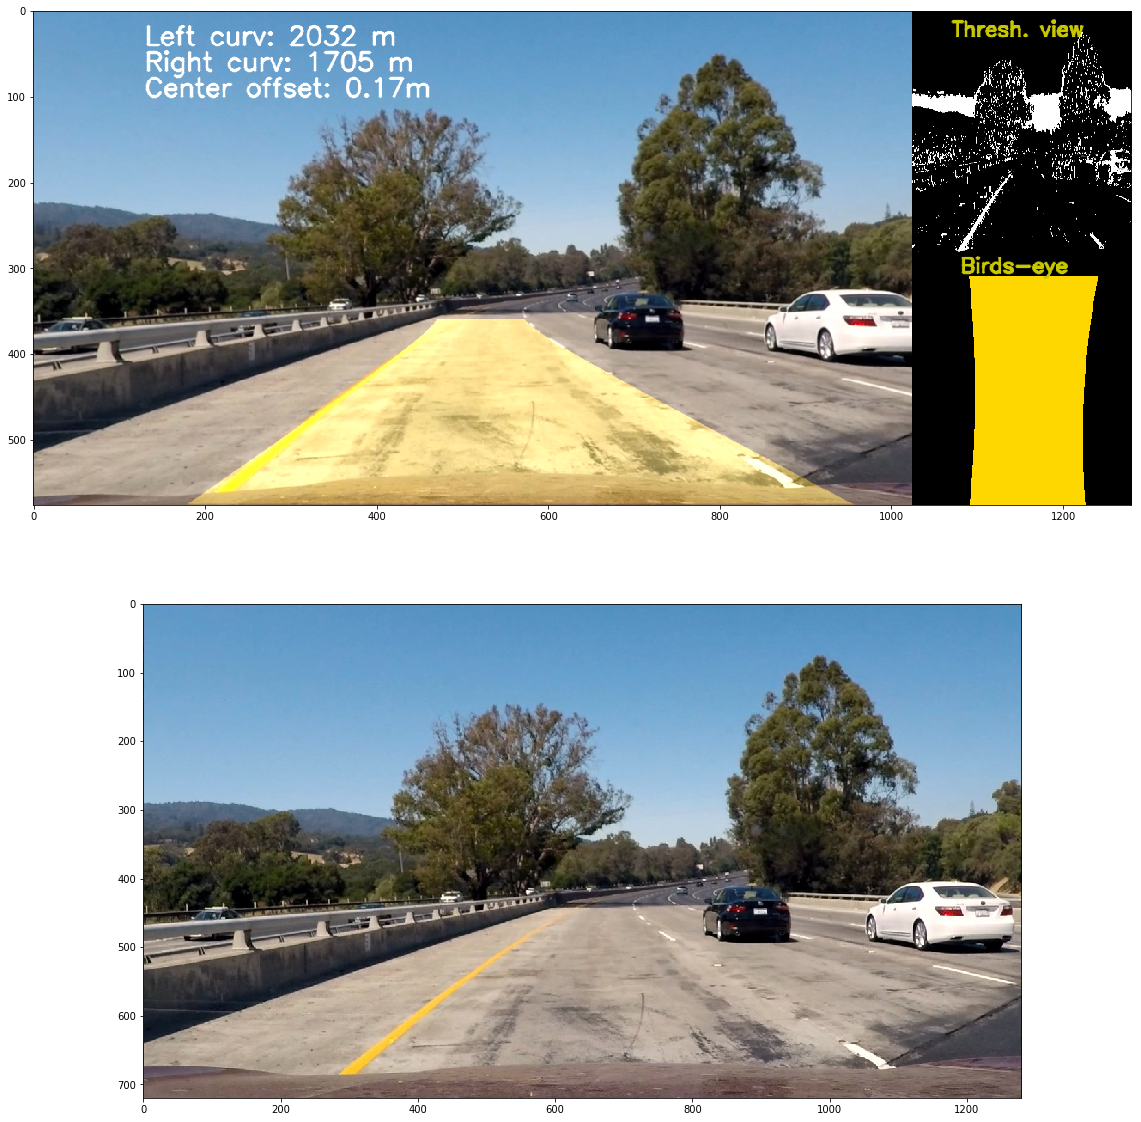

In [64]:
img = cv2.imread("test_images/test1.jpg")
#img = cv2.imread("test_images/straight_lines1.jpg")
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img2= process_image(imgRGB)

plt.figure(figsize=(10,15))
#plt.figure(figsize=(5,10))

  
plt.figure(figsize=(30,20))
plt.subplot(2,1,1)
plt.imshow(img2)
plt.subplot(2,1,2)
plt.imshow(imgRGB)

In [65]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import moviepy as mve

In [66]:
#Create video file pipeline
counter=0
output = 'out_test_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(22,25)
#clip1 = VideoFileClip("challenge_video.mp4")
#clip1 = VideoFileClip("challenge_video.mp4")

#clip1.save_frame("frame.jpeg")
#clip1 = clip1.fx(mve.vfx.rotate, lambda t: 90*t, expand=False)
out_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)
print(counter)

[MoviePy] >>>> Building video out_test_video.mp4
[MoviePy] Writing video out_test_video.mp4


100%|█████████▉| 1260/1261 [02:22<00:00,  8.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_test_video.mp4 

CPU times: user 2min 56s, sys: 26.9 s, total: 3min 23s
Wall time: 2min 22s
1260


In [68]:
HTML("""
<video  width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))